In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

# modelling
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.utils import resample

pd.set_option('display.max_colwidth', None)

2024-10-12 12:47:46.730396: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_data = pd.read_csv('/projects/sc73/ranzcr-clip-catheter-line-classification/train.csv')
train_annot = pd.read_csv('/projects/sc73/ranzcr-clip-catheter-line-classification/train_annotations.csv')

# Filtering data to only images with annotations

In [9]:
unique_annotated_images =  train_annot['StudyInstanceUID'].unique()
annotated = train_data[train_data['StudyInstanceUID'].isin(unique_annotated_images)]
annotated.head(1)

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
2,1.2.826.0.1.3680043.8.498.23819260719748494858948050424870692577,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5


In [16]:
annotated.shape

(9095, 13)

There are 9095 images with annotations

# Creating CVC binary/numeric

In [12]:
df = annotated.copy()

def classify_cvc(row):
    if row['CVC - Abnormal'] == 1 or row['CVC - Borderline'] == 1 or row['CVC - Normal'] == 1:
        return 'CVC'  # Label as 'CVC'
    else:
        return 'non-CVC'  # Label as 'non-CVC'

# Apply the function to create a new binary label column
df['CVC_binary'] = df.apply(classify_cvc, axis=1)
df['CVC_numeric'] = df['CVC_binary'].map({'CVC': 1, 'non-CVC': 0})
df.head(1)

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID,CVC_binary,CVC_numeric
2,1.2.826.0.1.3680043.8.498.23819260719748494858948050424870692577,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5,CVC,1


In [13]:
img_dir = "/projects/sc73/ranzcr-clip-catheter-line-classification/train/"
df['filename'] = img_dir + df['StudyInstanceUID'].astype(str) + ".jpg"

# Balancing CVC and non-CVC

In [14]:
df['CVC_numeric'].value_counts()

CVC_numeric
1    8866
0     229
Name: count, dtype: int64

There are 8866 CVC type, 229 non-CVC type

In [17]:
non_CVC = df[df['CVC_numeric'] == 0]
CVC = df[df['CVC_numeric'] == 1]


non_CVC_bal = resample(non_CVC, 
                       replace=True,    
                       n_samples=int(len(CVC)),  
                       random_state=42)
CVC_bal = resample(CVC,
                   replace=True,
                   n_samples=int(len(CVC)),
                   random_state=42)

bal_df = pd.concat([CVC_bal, non_CVC_bal])
bal_df = bal_df.sample(frac=1, random_state=42).reset_index(drop=True)
bal_df['CVC_numeric'].value_counts()

CVC_numeric
0    8866
1    8866
Name: count, dtype: int64

# Modelling CVC binary RESnet

In [18]:
# Data preprocessing and augmentation
img_size = (224, 224)
batch_size = 32
validation_split = 0.2  # 20% of the data will be used for validation

# Create a data generator with validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=validation_split  # Set validation split
)


# Training generator (80% of the data)
train_generator = datagen.flow_from_dataframe(
    dataframe=bal_df,
    x_col='filename',         # Column with image file paths
    y_col='CVC_binary',       # Use the new binary label column
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',      # Binary classification
    subset='training',
    shuffle=True
)



# validation generator (20% of data)
val_generator = datagen.flow_from_dataframe(
    dataframe=bal_df,
    x_col='filename',         # Column with image file paths
    y_col='CVC_binary',       # Use the new binary label column
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation', # Use validation subset
    shuffle = True
)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Found 14186 validated image filenames belonging to 2 classes.
Found 3546 validated image filenames belonging to 2 classes.


In [19]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the ResNet50 layers to retain the pre-trained weights
for layer in resnet.layers:
    layer.trainable = False

# Build the model
model = Sequential()

# Add the ResNet50 base model
model.add(resnet)

# Add global average pooling to reduce the feature maps
model.add(GlobalAveragePooling2D())

# Add a fully connected dense layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Add dropout to avoid overfitting

# Add the output layer for binary classification
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),  # Use a low learning rate for fine-tuning
              loss='binary_crossentropy',  # Binary classification
              metrics=['accuracy'])

2024-10-12 12:55:17.914517: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/11.0/extras/CUPTI/lib64:/usr/local/cuda/11.0/lib64:/usr/local/cuda/11.0/lib:/usr/local/cuda/11.0/lib64/stubs
2024-10-12 12:55:17.914568: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-10-12 12:55:17.914590: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (m3i004): /proc/driver/nvidia/version does not exist
2024-10-12 12:55:17.914849: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA


In [20]:
history = model.fit(
    train_generator,
    epochs=10,                      # Adjust epochs based on validation performance
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[early_stopping]       # Early stopping callback
)

Epoch 1/10
444/444 [==============================] - 2274s 5s/step - loss: 0.7178 - accuracy: 0.5154 - val_loss: 0.6872 - val_accuracy: 0.5821
Epoch 2/10
444/444 [==============================] - 2304s 5s/step - loss: 0.6886 - accuracy: 0.5417 - val_loss: 0.6858 - val_accuracy: 0.5877
Epoch 3/10
444/444 [==============================] - 2259s 5s/step - loss: 0.6857 - accuracy: 0.5487 - val_loss: 0.6836 - val_accuracy: 0.5897
Epoch 4/10
444/444 [==============================] - 2259s 5s/step - loss: 0.6838 - accuracy: 0.5473 - val_loss: 0.6826 - val_accuracy: 0.5632
Epoch 5/10
444/444 [==============================] - 2235s 5s/step - loss: 0.6832 - accuracy: 0.5534 - val_loss: 0.6804 - val_accuracy: 0.5801
Epoch 6/10
444/444 [==============================] - 2207s 5s/step - loss: 0.6787 - accuracy: 0.5640 - val_loss: 0.6782 - val_accuracy: 0.5778
Epoch 7/10
444/444 [==============================] - 2198s 5s/step - loss: 0.6782 - accuracy: 0.5536 - val_loss: 0.6759 - val_accuracy:

# Model Evaluation

In [22]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

111/111 [==============================] - 442s 4s/step - loss: 0.6705 - accuracy: 0.5964
Validation Loss: 0.6705045700073242
Validation Accuracy: 0.596446692943573


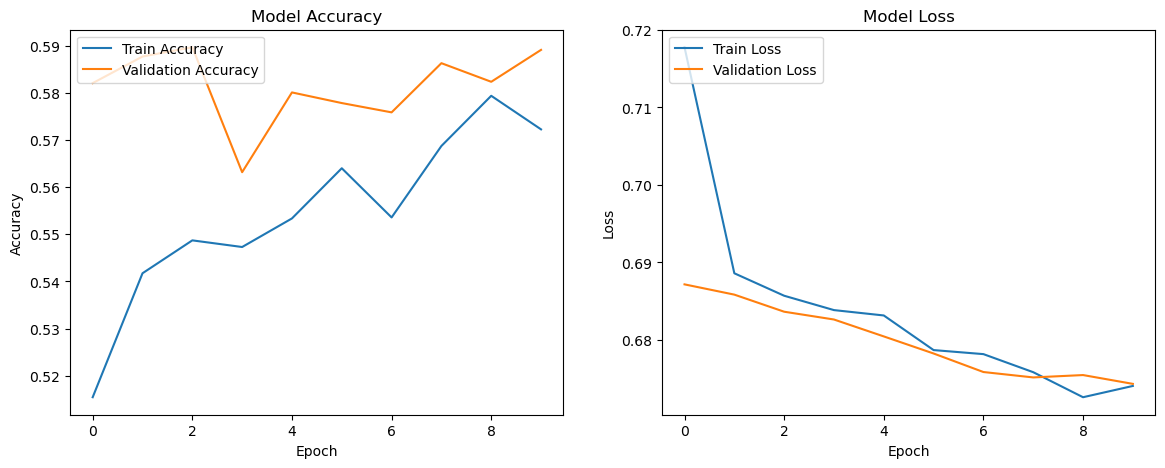

In [23]:
# Plotting training & validation accuracy values
plt.figure(figsize=(14, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

111/111 [==============================] - 439s 4s/step


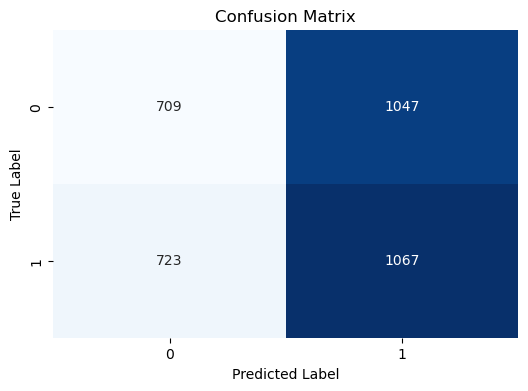

In [27]:
# Confusion Matrix of distribution of predicted and actual class labels

from sklearn.metrics import confusion_matrix

# Get true labels and predicted labels from validation set
y_true = val_generator.classes
y_pred = np.round(model.predict(val_generator))

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()